# Relative Difference Cut-off Experiment

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pandas as pd
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()
# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)
# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]
df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]
tagTrend = {'tagName' : df_count['index'], 'preGPT': df_count.iloc[:, 641:731].mean(axis = 1, skipna=True),
              'postGPT' : df_count.iloc[:, 731:].mean(axis = 1, skipna=True)}
tagTrend = pd.DataFrame(tagTrend)
# Convert nan to 0
tagTrend.fillna(0, inplace = True)
tagTrend['diff'] = (tagTrend['postGPT'] - tagTrend['preGPT'])/(tagTrend['preGPT']+0.1)

In [4]:
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result
# Define Entropy calculation function
def calculate_entropy(probabilities):
    """ Calculate the Shannon entropy of a given list of probabilities. """
    entropy = 0
    for p in probabilities:
        if p > 0:
            entropy += p * math.log(p, 2)
    return -entropy

### Model Experiment
- 1. HHI Measure
    - 1.1 HHI, Relative Difference, Quantile Cut-off
    - 1.2 HHI, Relative Difference, Bottom-K Cut-off
- 2. Entropy Measure
    - 2.1 Entropy, Relative Difference, Quantile Cut-off
    - 2.2 Entropy, Relative Difference, Bottom-K Cut-off

#### 1.1) HHI, Relative Difference, Quantile Cut-off

In [5]:
# try different lower_bounds
percentList = [0, 5, 10, 15, 20, 25]

result_df_hhi = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(percentList)):
    lower_bound = np.percentile(tagTrend['diff'], percentList[i]) # try 5, 10, 15, 20, 25
    # filter data without outliers
    cleaned_data = tagTrend[(tagTrend['diff'] >= lower_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    model = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model = pd.DataFrame({'cut_off_percentage':[percentList[i]], 'coef':[model.params['T_d:P_t']], 'std_err':[model.bse['T_d:P_t']], 'P_val':[model.pvalues['T_d:P_t']]})
    result_df_hhi = pd.concat([result_df_hhi, result_model], ignore_index = True)
    #result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_382629/999951282.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df_hhi = pd.concat([result_df_hhi, result_model], ignore_index = True)


In [6]:
result_df_hhi

,cut_off_percentage,coef,std_err,P_val
0,0,-0.215568,0.016569,1.072930e-38
1,5,-0.215351,0.016565,1.221520e-38
2,10,0.396196,0.019894,3.002899e-88
3,15,0.492538,0.023271,1.999550e-99
4,20,0.639902,0.037890,5.474496e-64
5,25,0.639902,0.037890,5.474496e-64


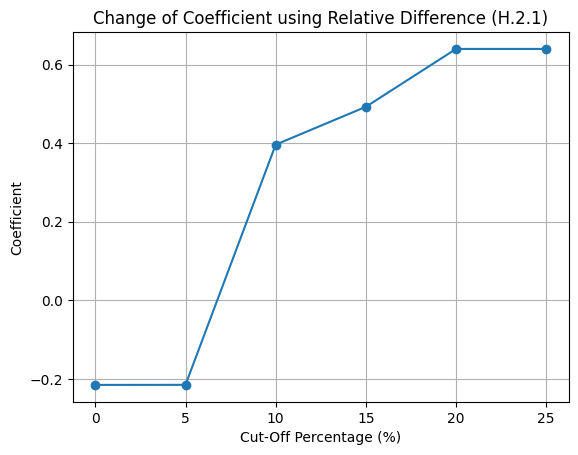

In [18]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_df_hhi['cut_off_percentage'], result_df_hhi['coef'], marker='o')  # Added a marker for each data point
# Adding title and labels
ax.set_title('Change of Coefficient using Relative Difference (H.2.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')
ax.grid(True)
# Display the plot
plt.show()

#### 1.2) HHI, Relative Difference, Bottom-K Cut-off

In [8]:
# cut-off bottom 0, 1, 3, 5, 10, 20]
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
result_df_hhi_k = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('diff', ascending = True)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']]})
    result_df_hhi_k = pd.concat([result_df_hhi_k, result_model_bottomK], ignore_index = True)
    #result_ls_bottomK.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_382629/2122575601.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df_hhi_k = pd.concat([result_df_hhi_k, result_model_bottomK], ignore_index = True)


In [9]:
result_df_hhi_k

,cut_off_percentage,coef,std_err,P_val
0,0,-0.215568,0.016569,1.072930e-38
1,2,-0.215385,0.016566,1.193830e-38
2,4,-0.215361,0.016565,1.212370e-38
3,6,-0.215360,0.016565,1.212444e-38
4,8,-0.215360,0.016565,1.212576e-38
5,10,-0.215357,0.016565,1.215494e-38
6,12,-0.215357,0.016565,1.215594e-38
7,14,-0.215357,0.016565,1.215689e-38
8,16,-0.215357,0.016565,1.215788e-38
9,18,-0.215357,0.016565,1.215874e-38


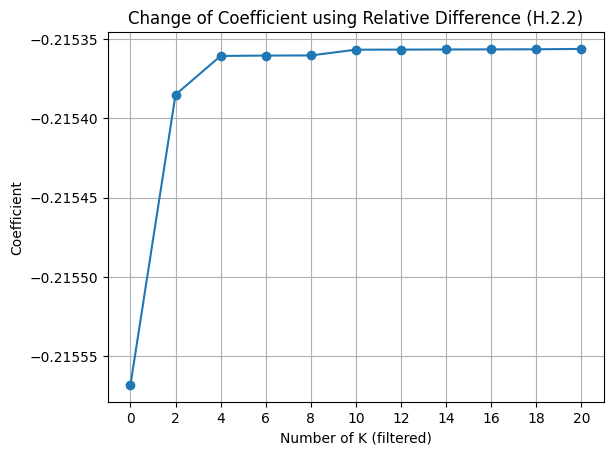

In [21]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_df_hhi_k['cut_off_percentage'].astype(str), result_df_hhi_k['coef'], marker='o')  # Added a marker for each data point
# Adding title and labels
ax.set_title('Change of Coefficient using Relative Difference (H.2.2)')
ax.set_xlabel('Number of K (filtered)')
ax.set_ylabel('Coefficient')
ax.grid(True)
# Display the plot
plt.show()

#### 2.1) Entropy, Relative Difference, Quantile Cut-off

In [11]:
# try different lower_bounds
percentList = [0, 5, 10, 15, 20, 25, 30]

result_df_ent = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(percentList)):
    lower_bound = np.percentile(tagTrend['diff'], percentList[i]) # try 5, 10, 15, 20, 25
    # filter data without outliers
    cleaned_data = tagTrend[(tagTrend['diff'] >= lower_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model = pd.DataFrame({'cut_off_percentage':[percentList[i]], 'coef':[model.params['T_d:P_t']], 'std_err':[model.bse['T_d:P_t']], 'P_val':[model.pvalues['T_d:P_t']]})
    result_df_ent = pd.concat([result_df_ent, result_model], ignore_index = True)
    #result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_382629/1462237248.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df_ent = pd.concat([result_df_ent, result_model], ignore_index = True)


In [13]:
result_df_ent

,cut_off_percentage,coef,std_err,P_val
0,0,0.040476,0.011251,3.210877e-04
1,5,0.042911,0.011280,1.423488e-04
2,10,0.099267,0.012309,7.330915e-16
3,15,0.154015,0.013127,8.710302e-32
4,20,0.199009,0.013784,3.013463e-47
5,25,0.199009,0.013784,3.013463e-47
6,30,0.199009,0.013784,3.013463e-47


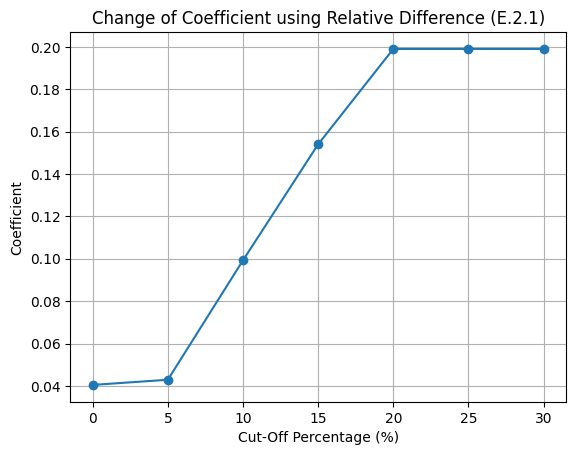

In [22]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_df_ent['cut_off_percentage'], result_df_ent['coef'], marker='o')  # Added a marker for each data point
# Adding title and labels
ax.set_title('Change of Coefficient using Relative Difference (E.2.1)')
ax.set_xlabel('Cut-Off Percentage (%)')
ax.set_ylabel('Coefficient')
ax.grid(True)
# Display the plot
plt.show()

#### 2.2) Entropy, Relative Difference, Bottom-K Cut-off

In [15]:
# cut-off bottom 0, 1, 3, 5, 10, 20]
cutoff_List = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #, 2618]
result_df_ent_k = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('diff', ascending = True)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Entropy score
    entropy_Score = []
    for j in range(3, cleansed.shape[1], 2):
        entropy_Score.append(calculate_entropy(cleansed.iloc[:, j]))
    result_entropy = pd.DataFrame({'year_month':year_month, 'ent_Score':entropy_Score})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().ent_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']]})
    result_df_ent_k = pd.concat([result_df_ent_k, result_model_bottomK], ignore_index = True)
    #result_ls_bottomK.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

/tmp/ipykernel_382629/1366875244.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df_ent_k = pd.concat([result_df_ent_k, result_model_bottomK], ignore_index = True)


In [16]:
result_df_ent_k

,cut_off_percentage,coef,std_err,P_val
0,0,0.040476,0.011251,0.000321
1,2,0.041673,0.011280,0.000220
2,4,0.042282,0.011293,0.000181
3,6,0.042289,0.011293,0.000181
4,8,0.042288,0.011293,0.000181
5,10,0.042366,0.011296,0.000176
6,12,0.042370,0.011295,0.000176
7,14,0.042377,0.011295,0.000176
8,16,0.042383,0.011295,0.000175
9,18,0.042389,0.011295,0.000175


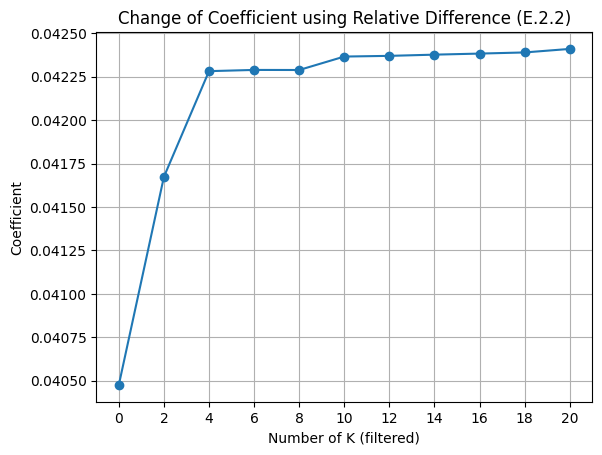

In [23]:
# Visualization
fig, ax = plt.subplots()
ax.plot(result_df_ent_k['cut_off_percentage'].astype(str), result_df_ent_k['coef'], marker='o')  # Added a marker for each data point
# Adding title and labels
ax.set_title('Change of Coefficient using Relative Difference (E.2.2)')
ax.set_xlabel('Number of K (filtered)')
ax.set_ylabel('Coefficient')
ax.grid(True)
# Display the plot
plt.show()